In [1]:
import os
import sys
import os
import glob
import random
import time
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision.models as models
from torchvision.models import VGG16_Weights

import torchvision.transforms.functional as F

from torchvision.transforms.functional import to_tensor, resize, center_crop, rotate, adjust_brightness

In [2]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

plt.style.use("dark_background")

IMG_SIZE = 512
MASK_SIZE = 128

In [3]:
def read_data_pathes(path):
    data_map = []
    for sub_dir_path in glob.glob(path+"*"):
        if not os.path.isdir(sub_dir_path):
            print("This is not a dir:", sub_dir_path)
            continue
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
        
    df = pd.DataFrame({'dirname' : data_map[::2], 'path' : data_map[1::2]})
    return df

df = read_data_pathes(DATA_PATH)
df.head(5)

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


,dirname,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [4]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

plt.style.use("dark_background")


In [5]:
def separate_and_sort_paths(df, base_len=89, end_img_len=4, end_mask_len=9):
    df_imgs = df[~df['path'].str.contains("mask")]
    df_masks = df[df['path'].str.contains("mask")]

    imgs = sorted(df_imgs["path"].values, key=lambda x: int(x[base_len:-end_img_len]))
    masks = sorted(df_masks["path"].values, key=lambda x: int(x[base_len:-end_mask_len]))

    df = pd.DataFrame({'patient': df_imgs.dirname.values, 'image_path': imgs, 'mask_path': masks})

    return imgs, masks, df

imgs, masks, df = separate_and_sort_paths(df)

In [6]:
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df['diagnosis'] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
# df.head()

In [7]:
def plot_histogram(df, ylabel='Image Count', title='Dataset Histogram'): 
    ax = df.diagnosis.value_counts().plot(kind='bar', stacked=True, figsize=(10, 6), color=selected_colors)

    for i, rows in enumerate(df.diagnosis.value_counts().values):
        ax.annotate(int(rows), 
                    xy=(i, rows-12), rotation=0, color='white', ha='center', verticalalignment='bottom', fontsize=15, fontweight='bold')

    bounding_box = dict(boxstyle='round', fc=('lightblue'), ec=('black'))
    ax.text(1.2, 2550, f"Total {len(df)} images", size=15, color='black', ha='center', va='center', bbox=bounding_box)
    ax.set_xticklabels(labels, rotation=45, fontsize=12);
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title,fontsize = 18, y=1.05)

def plot_distribution(df, ylabel='Total Images', title='Dataset Distribution'):
    patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
    patients_by_diagnosis.columns = ["Positive", "Negative"]
    
    ax = patients_by_diagnosis.plot(kind='bar',stacked=True, figsize=(18, 10), color=selected_colors, alpha=0.9)
    ax.legend(fontsize=20);
    ax.set_xlabel('Patients',fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.set_title(title,fontsize = 25, y=1.005)
    ax.set_xticklabels([])

def plot_masks(df):
    sample_df = sample_pos_df.values
    sample_imgs = []
    for i, data in enumerate(sample_df):
        img = resize(data[1], (IMG_SIZE, IMG_SIZE))
        mask = resize(data[2], (MASK_SIZE, MASK_SIZE))
        sample_imgs.extend([img, mask])
    
    sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
    sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))
    
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)
    
    grid[0].imshow(sample_imgs_arr)
    grid[0].set_title("Images", fontsize=15)
    grid[0].axis("off")
    grid[1].imshow(sample_masks_arr)
    grid[1].set_title("Masks", fontsize=15, y=0.9)
    grid[1].axis("off")
    plt.show()

def prepare_sample_images(df, row_count, sample_pos_df, sample_neg_df):
    sample_pos_df = sample_pos_df['image_path'].values
    sample_neg_df = sample_neg_df['image_path'].values

    sample_imgs = []
    for neg, pos in zip(sample_neg_df, sample_pos_df):
        neg_img = cv2.resize(cv2.imread(neg), (IMG_SIZE, IMG_SIZE))
        pos_img = cv2.resize(cv2.imread(pos), (IMG_SIZE, IMG_SIZE))
        sample_imgs.extend([pos_img, neg_img])

    sample_pos_arr = np.vstack(sample_imgs[::2])
    sample_neg_arr = np.vstack(sample_imgs[1::2])

    return sample_pos_arr, sample_neg_arr

In [8]:
def get_sample_df(df, type, expected, count, column=None):
    sample_df = df[df[type] == expected].sample(count)
    if column: return sample_df[column]
    return sample_df

def get_df_sample(df, type, expected, count):
    return get_sample_df(df, type, expected, count).values

def get_img_sample(df, type, expected, count):
    return get_sample_df(df, type, expected, count, column='image_path').values
    
def resize(img, size):
    return cv2.resize(cv2.imread(img), size)

def split(df, test_size):
    df1, df2 = train_test_split(df, stratify=df.diagnosis, test_size=test_size)
    return df1.reset_index(drop=True), df2.reset_index(drop=True) # Is this nessesary or we can del it, for cheating

def print_data_shapes(train_df, val_df, test_df):
    print(f"{'Dataset':<10} {'Shape':<15}")
    print(f"{'-'*25}")
    print(f"{'Train':<10} {train_df.shape}")
    print(f"{'Validation':<10} {val_df.shape}")
    print(f"{'Test':<10} {test_df.shape}")

positive_color = 'lightseagreen' 
negative_color = 'violet'
labels = ['Positive', 'Negative']
selected_colors = [positive_color, negative_color]
colors = ['mediumvioletred', 'springgreen']
sample_pos_df = get_sample_df(df, 'diagnosis', expected=1, count=3)
sample_neg_df = get_sample_df(df, 'diagnosis', expected=0, count=3)

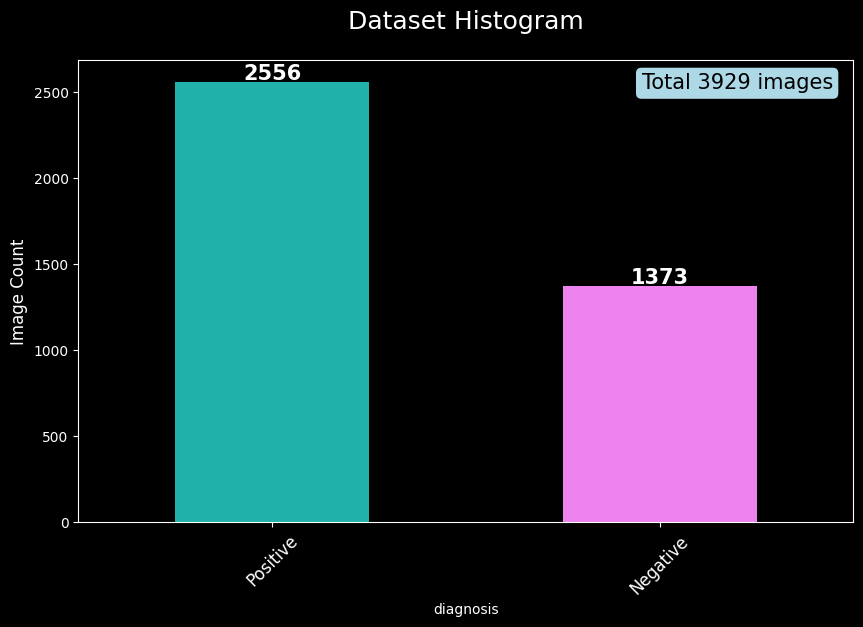

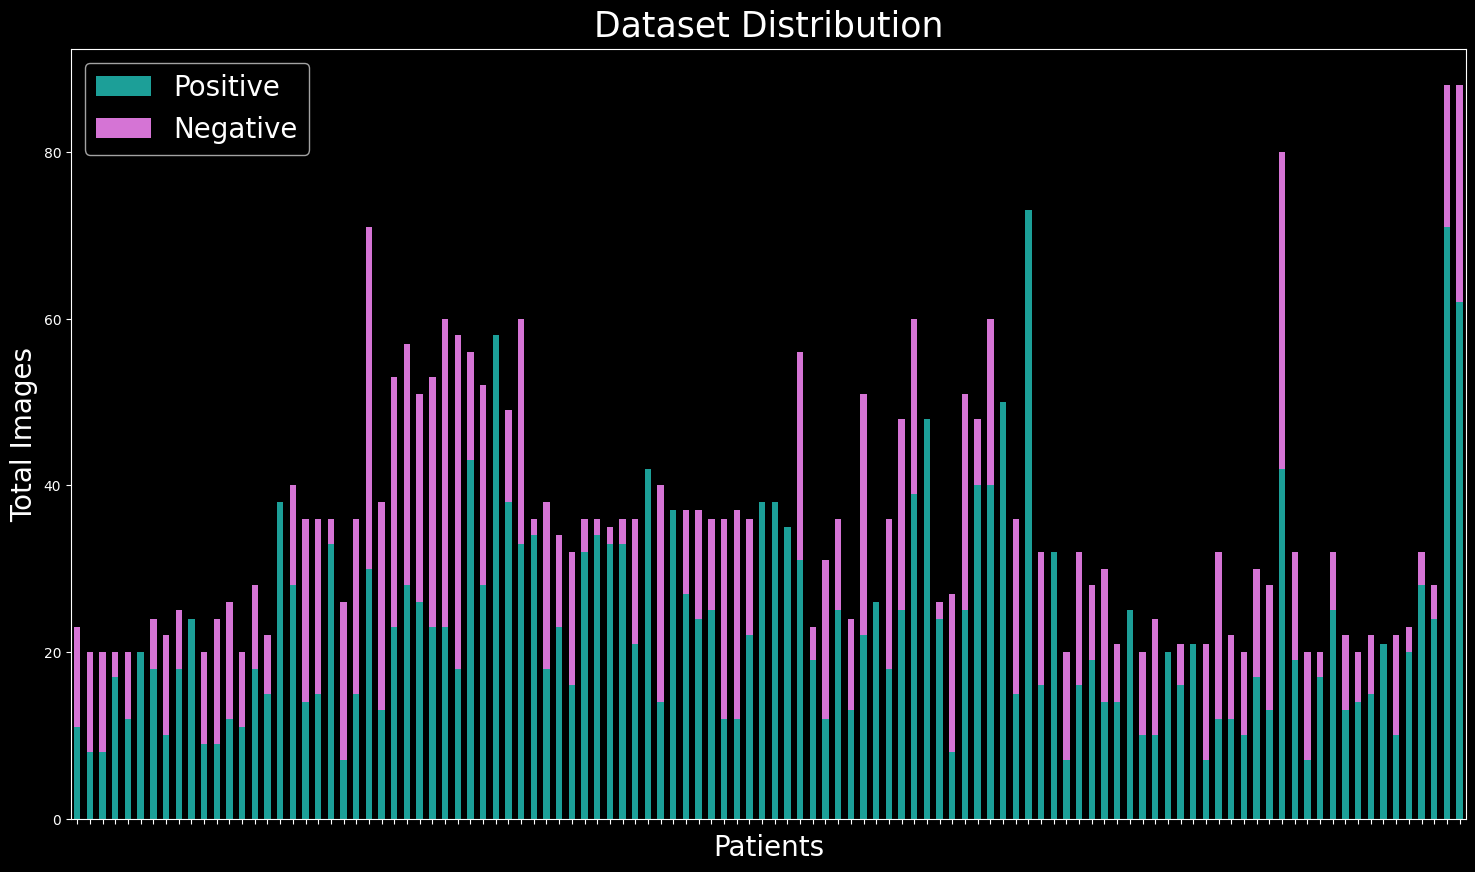

In [9]:
plot_histogram(df)
plot_distribution(df)
# plot_masks(df)

In [10]:
# sample_yes_arr, sample_no_arr = prepare_sample_images(df, row_count=3, sample_pos_df, sample_neg_df)
# # Plot
# fig = plt.figure(figsize=(10, 10))
# grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.1)

# grid[0].imshow(sample_yes_arr)
# grid[0].set_title("Positive")
# grid[0].axis("off")

# grid[1].imshow(sample_no_arr)
# grid[1].set_title("Negative")
# grid[1].axis("off")

# grid[2].imshow(sample_yes_arr[:, :, 0], cmap="hot")
# grid[2].set_title("Positive")
# grid[2].axis("off")

# grid[3].imshow(sample_no_arr[:, :, 0], cmap="hot")
# grid[3].set_title("Negative")
# grid[3].axis("off")

# plt.figtext(0.36, 0.90, "Original", va="center", ha="center", size=15)
# plt.figtext(0.66, 0.90, "With hot colormap", va="center", ha="center", size=15)
# plt.show()


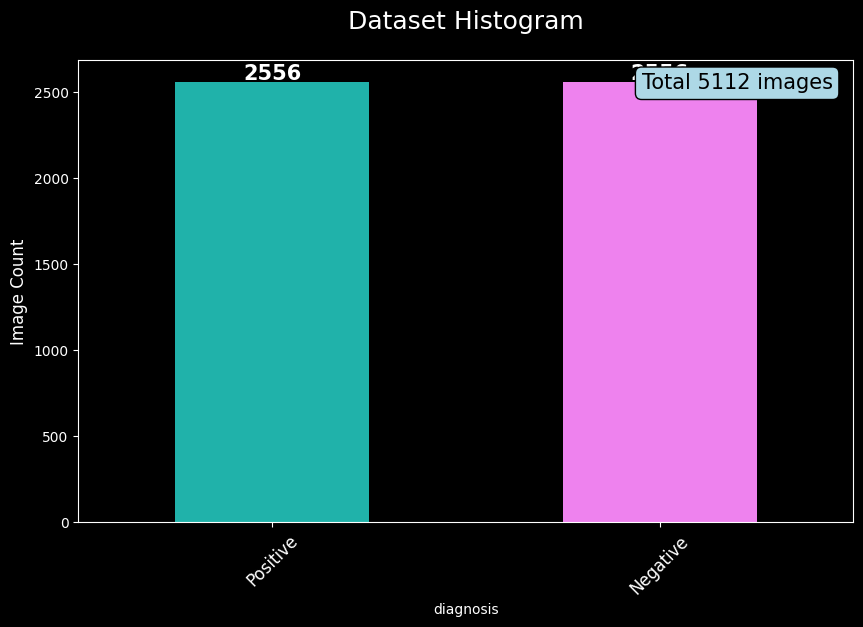

In [11]:
def upsample_dataset(initial_df):
    pos_counts = initial_df['diagnosis'].value_counts() 
    max_count = pos_counts.max()

    # Collect all dataframes with repeated undersampled entries
    dfs = []
    for label, count in pos_counts.items():
        subset_df = initial_df[initial_df['diagnosis'] == label]
        if count < max_count:
            repeat_count = max_count - count
            repeated_subset_df = subset_df.sample(repeat_count, replace=True)
            dfs.append(repeated_subset_df)
    
    # Combine the original DataFrame with the upsampled data
    initial_df = pd.concat([initial_df] + dfs, ignore_index=True).sample(frac=1).reset_index(drop=True)
    return initial_df

df = upsample_dataset(df)
plot_histogram(df)

In [12]:
train_df, temp_df = split(df, test_size=0.2)
test_df, val_df = split(temp_df, test_size=0.5)

print_data_shapes(train_df, val_df, test_df)

Dataset    Shape          
-------------------------
Train      (4089, 4)
Validation (512, 4)
Test       (511, 4)


## Model

In [13]:
# class AugmentPair:
#     def __init__(self, rotation_range=30, scale_range=0.2, brightness_range=(0.8, 1.2)):
#         self.rotation_range = rotation_range
#         self.scale_range = scale_range
#         self.brightness_range = brightness_range

#     def __call__(self, pair):
#         image, mask = pair

#         # Random rotation
#         angle = np.random.uniform(-self.rotation_range, self.rotation_range)
#         image = rotate(image, angle)
#         mask = rotate(mask, angle)

#         # Random scaling (resize)
#         scale_factor = np.random.uniform(1 - self.scale_range, 1 + self.scale_range)
#         width, height = image.size
#         new_size = (int(height * scale_factor), int(width * scale_factor))
#         image = F.resize(image, new_size)
#         mask = F.resize(mask, new_size)

#         # Center crop back to original size
#         image = F.center_crop(image, (height, width))
#         mask = F.center_crop(mask, (height, width))

#         # Random brightness adjustment
#         brightness_factor = np.random.uniform(*self.brightness_range)
#         image = adjust_brightness(image, brightness_factor)

#         return image, mask


In [14]:
from torchvision.transforms.functional import resize
class AugmentPair:
    def __init__(self, rotation_range=15, scale_range=0.2, brightness_range=(0.9, 1.1)):
        self.rotation_range = rotation_range
        self.scale_range = scale_range
        self.brightness_range = brightness_range

    def rotate(self, input, angle):
        return rotate(input, angle)

    def scale(self, data, factor):
        width, height = data.size
        data = resize(data, (int(height * factor), int(width * factor)))
        return center_crop(data, (height, width))
    
    def adjust_brightness(self, input, factor):
        return adjust_brightness(input, factor)        
        
    def __call__(self, pair):
        image, mask = pair

        angle = np.random.uniform(-self.rotation_range, self.rotation_range)
        image = self.rotate(image, angle)
        mask = self.rotate(mask, angle)

        factor = np.random.uniform(1 - self.scale_range, 1 + self.scale_range)
        image = self.scale(image, factor)
        mask = self.scale(mask, factor)

        image = self.adjust_brightness(image, factor=np.random.uniform(*self.brightness_range))

        return image, mask

class MRIDataset(Dataset):
    def __init__(self, df, transformer=None):
        self.df = df
        self.transformer = transformer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image and mask with OpenCV
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)  # 0 for grayscale

        # Convert to PIL Image
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        mask = Image.fromarray(mask)

        # Apply transformations if provided
        real_image = image
        real_mask = mask
        if self.transformer:
            image, mask = self.transformer((image, mask))

        # Convert to tensors
        real_image = to_tensor(real_image)
        real_mask = torch.tensor(np.array(mask) / 255.0, dtype=torch.float32).unsqueeze(0)
        image = to_tensor(image)
        mask = torch.tensor(np.array(mask) / 255.0, dtype=torch.float32).unsqueeze(0)

        return image, resize(mask, MASK_SIZE)


train_dataset = MRIDataset(train_df, transformer=AugmentPair())
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)

val_dataset = MRIDataset(val_df, transformer=None)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)

test_dataset = MRIDataset(test_df, transformer=None)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)

images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

torch.Size([26, 3, 256, 256]) torch.Size([26, 1, 128, 128])


In [18]:
def plot_aug(data, mask=False):
    ncols, nrows = len(data), 1
    size = MASK_SIZE if mask else IMG_SIZE
    plt.figure(figsize=(ncols * (size / 100), nrows * (size / 100)))
    plt.subplots_adjust(wspace=0., hspace=0.)
    idx = 0
    for img in data:
        if mask:
            img = img.numpy().astype(np.float32)[0, :, :]
        else:
            img = img.numpy().transpose(1, 2, 0)

        plt.subplot(nrows, ncols, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        idx += 1

    return plt.show()

In [19]:
# combined_df = pd.concat([sample_pos_df, sample_neg_df], ignore_index=True)
# shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
# dataloader_ = DataLoader(MRIDataset(shuffled_df, transformer=AugmentPair()), 
#                          batch_size=32, num_workers=4, shuffle=True)

# images_, masks_, real_images_, real_masks_ = next(iter(dataloader_))
# plot_aug(images_)
# plot_aug(masks_)
# plot_aug(real_images_)
# plot_aug(real_masks_)

In [20]:
import torch
import torch.nn as nn

class VGGEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super(VGGEncoder, self).__init__()
        weights = VGG16_Weights.IMAGENET1K_V1 if pretrained else None
        vgg = models.vgg16(weights=weights)
        features = list(vgg.features.children())
        # Extract blocks for skip connections
        self.block1 = nn.Sequential(*features[:5])   # block1_pool
        self.block2 = nn.Sequential(*features[5:10]) # block2_pool
        self.block3 = nn.Sequential(*features[10:17])# block3_pool
        self.block4 = nn.Sequential(*features[17:24])# block4_pool
        self.block5 = nn.Sequential(*features[24:31])# block5_pool

    def forward(self, x):
        skip_connections = []
        x = self.block1(x)
        # print('blck1:', x.shape)
        skip_connections.append(x)
        x = self.block2(x)
        # print('blck2:', x.shape)
        skip_connections.append(x)
        x = self.block3(x)
        # print('blck3:', x.shape)
        skip_connections.append(x)
        x = self.block4(x)
        # print('blck4:', x.shape)
        skip_connections.append(x)
        x = self.block5(x)
        # print('blck5:', x.shape)
        # print()
        # print('VGG output shape:', x.shape)
        return x, skip_connections[::-1]  # Reverse for decoding
        
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.upsample(x)  # Upsample
        x = torch.cat([x, skip], dim=1)  # Concatenate with skip connection
        x = self.relu(self.conv1(x))  # First convolution
        x = self.relu(self.conv2(x))  # Second convolution
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_classes=1):
        super(UNetDecoder, self).__init__()
        self.decoder4 = DecoderBlock(512, 512, 256)  # Block 5 to Block 4
        self.decoder3 = DecoderBlock(256, 256, 128)  # Block 4 to Block 3
        self.decoder2 = DecoderBlock(128, 128, 64)   # Block 3 to Block 2
        self.decoder1 = DecoderBlock(64, 64, 32)     # Block 2 to Block 1

        # Final output layer
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x, skips):
        x = self.decoder4(x, skips[0])  # Skip from Block 4
        x = self.decoder3(x, skips[1])  # Skip from Block 3
        x = self.decoder2(x, skips[2])  # Skip from Block 2
        x = self.decoder1(x, skips[3])  # Skip from Block 1
        x = self.final_conv(x)          # Output layer
        return x

class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        self.encoder = VGGEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        x, skips = self.encoder(x)  # Encoder forward pass
        x = self.decoder(x, skips)  # Decoder forward pass
        return x



In [21]:
from tqdm import tqdm
# Step 5: Set hyperparameters
EPOCHS = 20
BATCH_SIZE = 8

def dice_coefficient(output, target, smooth=1e-6):
    output = (output > 0.5).float()
    intersection = (output * target).sum()
    return (2.0 * intersection + smooth) / (output.sum() + target.sum() + smooth)
# # def dice_coef_metric(inputs, target):
#     intersection = 2.0 * (target * output).sum()
#     union = target.sum() + output.sum()
#     if target.sum() == 0 and output.sum() == 0:
#         return 1.0

#     return intersection / union

def iou_score(output, target, smooth=1e-6):
    output = (output > 0.5).float()
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(output, target, smooth=1e-6):
    intersection = (output * target).sum()
    return 1 - (2.0 * intersection + smooth) / (output.sum() + target.sum() + smooth)
    # smooth = 1.0
    # intersection = 2.0 * ((target * output).sum()) + smooth
    # union = target.sum() + output.sum() + smooth

    # return 1 - (intersection / union)

In [22]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, total_dice, total_iou = 0, 0, 0

    for images, masks in tqdm(dataloader, desc="Training", leave=False):    
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks) + criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks).item()
        total_iou += iou_score(outputs, masks).item()

    return (total_loss / len(dataloader)), (total_dice / len(dataloader)), (total_iou / len(dataloader))

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_dice, total_iou = 0, 0, 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = dice_loss(outputs, masks) + criterion(outputs, masks)
            total_loss += loss.item()
            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

    return total_loss / len(dataloader), total_dice / len(dataloader), total_iou / len(dataloader)


In [23]:
def test_model(model, dataloader, device):
    model.eval()
    total_dice, total_iou = 0, 0
    samples = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

            # Store sample predictions for visualization
            samples.append((images.cpu(), masks.cpu(), outputs.cpu()))

    avg_dice = total_dice / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    
    return avg_dice, avg_iou, samples


In [24]:
model = UNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=3e-4)

num_epochs = 150
patience = 5  # Stop training if no improvement for 'patience' epochs
best_val_loss = np.inf  # Initialize best validation loss to infinity
early_stop_counter = 0

train_losses, val_losses = [], []
train_dice_scores, val_dice_scores = [], []

for epoch in range(num_epochs):
    train_loss, train_dice, train_iou = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_dice, val_iou = validate_one_epoch(model, val_dataloader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dice_scores.append(train_dice)
    val_dice_scores.append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter when improvement is found
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Training complete.")


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 238MB/s] 


Epoch 1/150
Train Loss: 1.0809, Train Dice: 0.0000, Train IoU: 0.0000
Val Loss: 1.0258, Val Dice: 0.0000, Val IoU: 0.0000


Epoch 2/150
Train Loss: 1.0258, Train Dice: 0.0805, Train IoU: 0.0494
Val Loss: 1.0202, Val Dice: 0.1896, Val IoU: 0.1065


Epoch 3/150
Train Loss: 1.0208, Train Dice: 0.4633, Train IoU: 0.3241
Val Loss: 1.0168, Val Dice: 0.6080, Val IoU: 0.4405


Epoch 4/150
Train Loss: 1.0172, Train Dice: 0.6959, Train IoU: 0.5469
Val Loss: 1.0139, Val Dice: 0.8019, Val IoU: 0.6724


Epoch 5/150
Train Loss: 1.0168, Train Dice: 0.7483, Train IoU: 0.6081
Val Loss: 1.0168, Val Dice: 0.7502, Val IoU: 0.6038


Epoch 6/150
Train Loss: 1.0147, Train Dice: 0.7766, Train IoU: 0.6424
Val Loss: 1.0102, Val Dice: 0.8509, Val IoU: 0.7434


Epoch 7/150
Train Loss: 1.0100, Train Dice: 0.8516, Train IoU: 0.7433
Val Loss: 1.0090, Val Dice: 0.8666, Val IoU: 0.7666


Epoch 8/150
Train Loss: 1.0089, Train Dice: 0.8647, Train IoU: 0.7630
Val Loss: 1.0089, Val Dice: 0.8778, Val IoU: 0.7840


Epoch 9/150
Train Loss: 1.0087, Train Dice: 0.8676, Train IoU: 0.7678
Val Loss: 1.0089, Val Dice: 0.8520, Val IoU: 0.7445


Epoch 10/150
Train Loss: 1.0080, Train Dice: 0.8784, Train IoU: 0.7842
Val Loss: 1.0080, Val Dice: 0.8718, Val IoU: 0.7748


Epoch 11/150
Train Loss: 1.0162, Train Dice: 0.7288, Train IoU: 0.6016
Val Loss: 1.0101, Val Dice: 0.8489, Val IoU: 0.7399


Epoch 12/150
Train Loss: 1.0099, Train Dice: 0.8517, Train IoU: 0.7444
Val Loss: 1.0106, Val Dice: 0.8482, Val IoU: 0.7399


Epoch 13/150
Train Loss: 1.0080, Train Dice: 0.8778, Train IoU: 0.7834
Val Loss: 1.0076, Val Dice: 0.8797, Val IoU: 0.7869


Epoch 14/150
Train Loss: 1.0076, Train Dice: 0.8828, Train IoU: 0.7913
Val Loss: 1.0072, Val Dice: 0.8926, Val IoU: 0.8073


Epoch 15/150
Train Loss: 1.0074, Train Dice: 0.8861, Train IoU: 0.7965
Val Loss: 1.0073, Val Dice: 0.8797, Val IoU: 0.7869


Epoch 16/150
Train Loss: 1.0072, Train Dice: 0.8859, Train IoU: 0.7965
Val Loss: 1.0072, Val Dice: 0.8856, Val IoU: 0.7963


Epoch 17/150
Train Loss: 1.0072, Train Dice: 0.8902, Train IoU: 0.8033
Val Loss: 1.0171, Val Dice: 0.8450, Val IoU: 0.7343


Epoch 18/150
Train Loss: 1.0091, Train Dice: 0.8638, Train IoU: 0.7630
Val Loss: 1.0074, Val Dice: 0.8934, Val IoU: 0.8089


Epoch 19/150
Train Loss: 1.0068, Train Dice: 0.8919, Train IoU: 0.8060
Val Loss: 1.0069, Val Dice: 0.8893, Val IoU: 0.8019


Epoch 20/150
Train Loss: 1.0064, Train Dice: 0.8996, Train IoU: 0.8181
Val Loss: 1.0068, Val Dice: 0.8892, Val IoU: 0.8017


Epoch 21/150
Train Loss: 1.0063, Train Dice: 0.9020, Train IoU: 0.8219
Val Loss: 1.0071, Val Dice: 0.8904, Val IoU: 0.8039


Epoch 22/150
Train Loss: 1.0061, Train Dice: 0.9041, Train IoU: 0.8255
Val Loss: 1.0067, Val Dice: 0.8923, Val IoU: 0.8069


Epoch 23/150
Train Loss: 1.0060, Train Dice: 0.9044, Train IoU: 0.8262
Val Loss: 1.0077, Val Dice: 0.8987, Val IoU: 0.8174


Epoch 24/150
Train Loss: 1.0062, Train Dice: 0.9023, Train IoU: 0.8227
Val Loss: 1.0073, Val Dice: 0.8948, Val IoU: 0.8111


Epoch 25/150
Train Loss: 1.0063, Train Dice: 0.9009, Train IoU: 0.8205
Val Loss: 1.0069, Val Dice: 0.9063, Val IoU: 0.8296


Epoch 26/150
Train Loss: 1.0059, Train Dice: 0.9078, Train IoU: 0.8316
Val Loss: 1.0065, Val Dice: 0.9009, Val IoU: 0.8207


Epoch 27/150
Train Loss: 1.0057, Train Dice: 0.9094, Train IoU: 0.8344
Val Loss: 1.0069, Val Dice: 0.8756, Val IoU: 0.7799


Epoch 28/150
Train Loss: 1.0075, Train Dice: 0.8859, Train IoU: 0.7967
Val Loss: 1.0083, Val Dice: 0.8856, Val IoU: 0.7961


Epoch 29/150
Train Loss: 1.0067, Train Dice: 0.8960, Train IoU: 0.8129
Val Loss: 1.0066, Val Dice: 0.8982, Val IoU: 0.8164


Epoch 30/150
Train Loss: 1.0057, Train Dice: 0.9103, Train IoU: 0.8358
Val Loss: 1.0064, Val Dice: 0.8996, Val IoU: 0.8187


Epoch 31/150
Train Loss: 1.0056, Train Dice: 0.9096, Train IoU: 0.8347
Val Loss: 1.0066, Val Dice: 0.9089, Val IoU: 0.8340


Epoch 32/150
Train Loss: 1.0056, Train Dice: 0.9115, Train IoU: 0.8378
Val Loss: 1.0065, Val Dice: 0.8899, Val IoU: 0.8028


Epoch 33/150
Train Loss: 1.0053, Train Dice: 0.9149, Train IoU: 0.8435
Val Loss: 1.0064, Val Dice: 0.9076, Val IoU: 0.8317


Epoch 34/150
Train Loss: 1.0053, Train Dice: 0.9157, Train IoU: 0.8449
Val Loss: 1.0070, Val Dice: 0.9015, Val IoU: 0.8217


Epoch 35/150
Train Loss: 1.0052, Train Dice: 0.9173, Train IoU: 0.8476
Val Loss: 1.0059, Val Dice: 0.9123, Val IoU: 0.8395


Epoch 36/150
Train Loss: 1.0051, Train Dice: 0.9189, Train IoU: 0.8503
Val Loss: 1.0059, Val Dice: 0.9113, Val IoU: 0.8378


Epoch 37/150
Train Loss: 1.0050, Train Dice: 0.9182, Train IoU: 0.8490
Val Loss: 1.0066, Val Dice: 0.8977, Val IoU: 0.8154


Epoch 38/150
Train Loss: 1.0049, Train Dice: 0.9192, Train IoU: 0.8510
Val Loss: 1.0060, Val Dice: 0.9106, Val IoU: 0.8367


Epoch 39/150
Train Loss: 1.0056, Train Dice: 0.9082, Train IoU: 0.8332
Val Loss: 1.0078, Val Dice: 0.8865, Val IoU: 0.7978


Epoch 40/150
Train Loss: 1.0075, Train Dice: 0.8852, Train IoU: 0.7965
Val Loss: 1.0088, Val Dice: 0.8770, Val IoU: 0.7828


Epoch 41/150
Train Loss: 1.0063, Train Dice: 0.9004, Train IoU: 0.8204
Val Loss: 1.0068, Val Dice: 0.9082, Val IoU: 0.8327
Early stopping triggered at epoch 41
Training complete.


In [25]:
# model = UNet()
# # print(model)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = Adam(model.parameters(), lr=0.0001)

# num_epochs = 10
# train_losses, val_losses = [], []
# train_dice_scores, val_dice_scores = [], []

# for epoch in range(num_epochs):
#     train_loss, train_dice, train_iou = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
#     val_loss, val_dice, val_iou = validate_one_epoch(model, val_dataloader, criterion, device)

#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     train_dice_scores.append(train_dice)
#     val_dice_scores.append(val_dice)

#     print(f"Epoch {epoch+1}/{num_epochs}")
#     print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
#     print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")


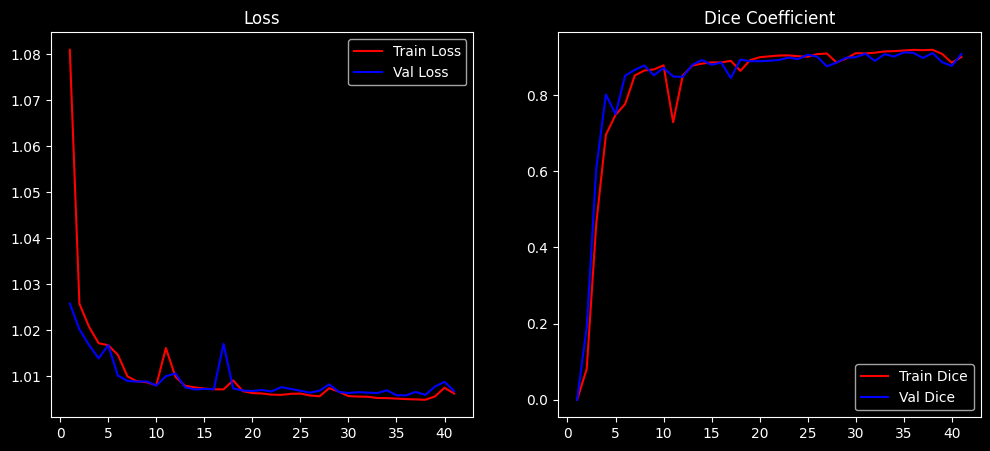

In [26]:
def plot_metrics(train_losses, val_losses, train_dice_scores, val_dice_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Train Loss')
    plt.plot(epochs, val_losses, 'b', label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dice_scores, 'r', label='Train Dice')
    plt.plot(epochs, val_dice_scores, 'b', label='Val Dice')
    plt.title('Dice Coefficient')
    plt.legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_dice_scores, val_dice_scores)


In [27]:
state_dict = torch.load("best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)  # Ensure the model is on the correct device
test_loss, test_dice, test_iou = validate_one_epoch(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Dice: {test_dice:.4f}, Test IoU: {test_iou:.4f}")


/tmp/ipykernel_23/1717056291.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_model.pth", map_location=device)
                             

Test Loss: 1.0053, Test Dice: 0.9191, Test IoU: 0.8507


In [28]:
# image
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

pred = model.forward(image)



# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = model(pred.to(device))
pred = validate_one_epoch(model, test_dataloader, criterion, device)
pred = pred.detach().cpu().numpy()[0,0,:,:]

# # pred with tshd
# pred_t = np.copy(pred)
# pred_t[np.nonzero(pred_t < 0.3)] = 0.0
# pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
# pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

NameError: name 'rx50' is not defined